**Paso 1: Importación de Librerías**

In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Descargar stopwords
nltk.download('stopwords')
nltk.download('punkt')

2024-09-18 12:09:14.928476: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-18 12:09:16.132677: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-18 12:09:16.304782: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-18 12:09:17.615168: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-18 12:09:29.056027: W tensorflow/compiler/tf2

True

**Paso 2: Cargar Dataset**

Para este proyecto, usaremos un dataset de reseñas de productos disponible en la web. Vamos a utilizar el dataset de Amazon (se puede encontrar en Kaggle).

In [2]:
# Cargar dataset desde un archivo TSV (por ejemplo, reseñas de restaurantes)
url = '/home/julio/jupyter_files/Curso_ML/Restaurant_Reviews.tsv'
df = pd.read_csv(url, sep='\t')  # Se especifica 'sep' para asegurarse de que use tabulación

# Mostrar las primeras filas del dataset
df.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  1000 non-null   object
 1   Liked   1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [4]:
#**Preprocesamiento de Textos**

In [5]:
def clean_text(text):
    text = re.sub(r'\d+', '', text)  # Eliminar números
    text = re.sub(r'[^\w\s]', '', text)  # Eliminar signos de puntuación
    text = text.lower()  # Convertir a minúsculas
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)

In [6]:
df['Cleaned_Review'] = df['Review'].apply(clean_text)

In [7]:
#Análisis de Polaridad y Subjetividad

In [8]:
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity, analysis.sentiment.subjectivity

In [9]:
df[['Polarity', 'Subjectivity']] = df['Cleaned_Review'].apply(lambda x: pd.Series(get_sentiment(x)))

In [10]:
#Análisis de Sentimientos con VADER

In [11]:
# Inicializar el analizador VADER
analyzer = SentimentIntensityAnalyzer()

def get_vader_emotions(text):
    sentiment = analyzer.polarity_scores(text)
    return sentiment['compound'], sentiment['pos'], sentiment['neu'], sentiment['neg']

In [12]:
df[['Compound', 'Positive', 'Neutral', 'Negative']] = df['Cleaned_Review'].apply(lambda x: pd.Series(get_vader_emotions(x)))

In [13]:
#Análisis de Emociones con transformers

In [14]:
# Cargar el pipeline de emociones
emotion_pipeline = pipeline('text-classification', model='bhadresh-savani/bert-base-uncased-emotion')

def get_emotions(text):
    result = emotion_pipeline(text)
    return result[0]['label'], result[0]['score']

/home/julio/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [15]:
df[['Emotion_Label', 'Emotion_Score']] = df['Cleaned_Review'].apply(lambda x: pd.Series(get_emotions(x)))

In [16]:
#Visualización de Resultados

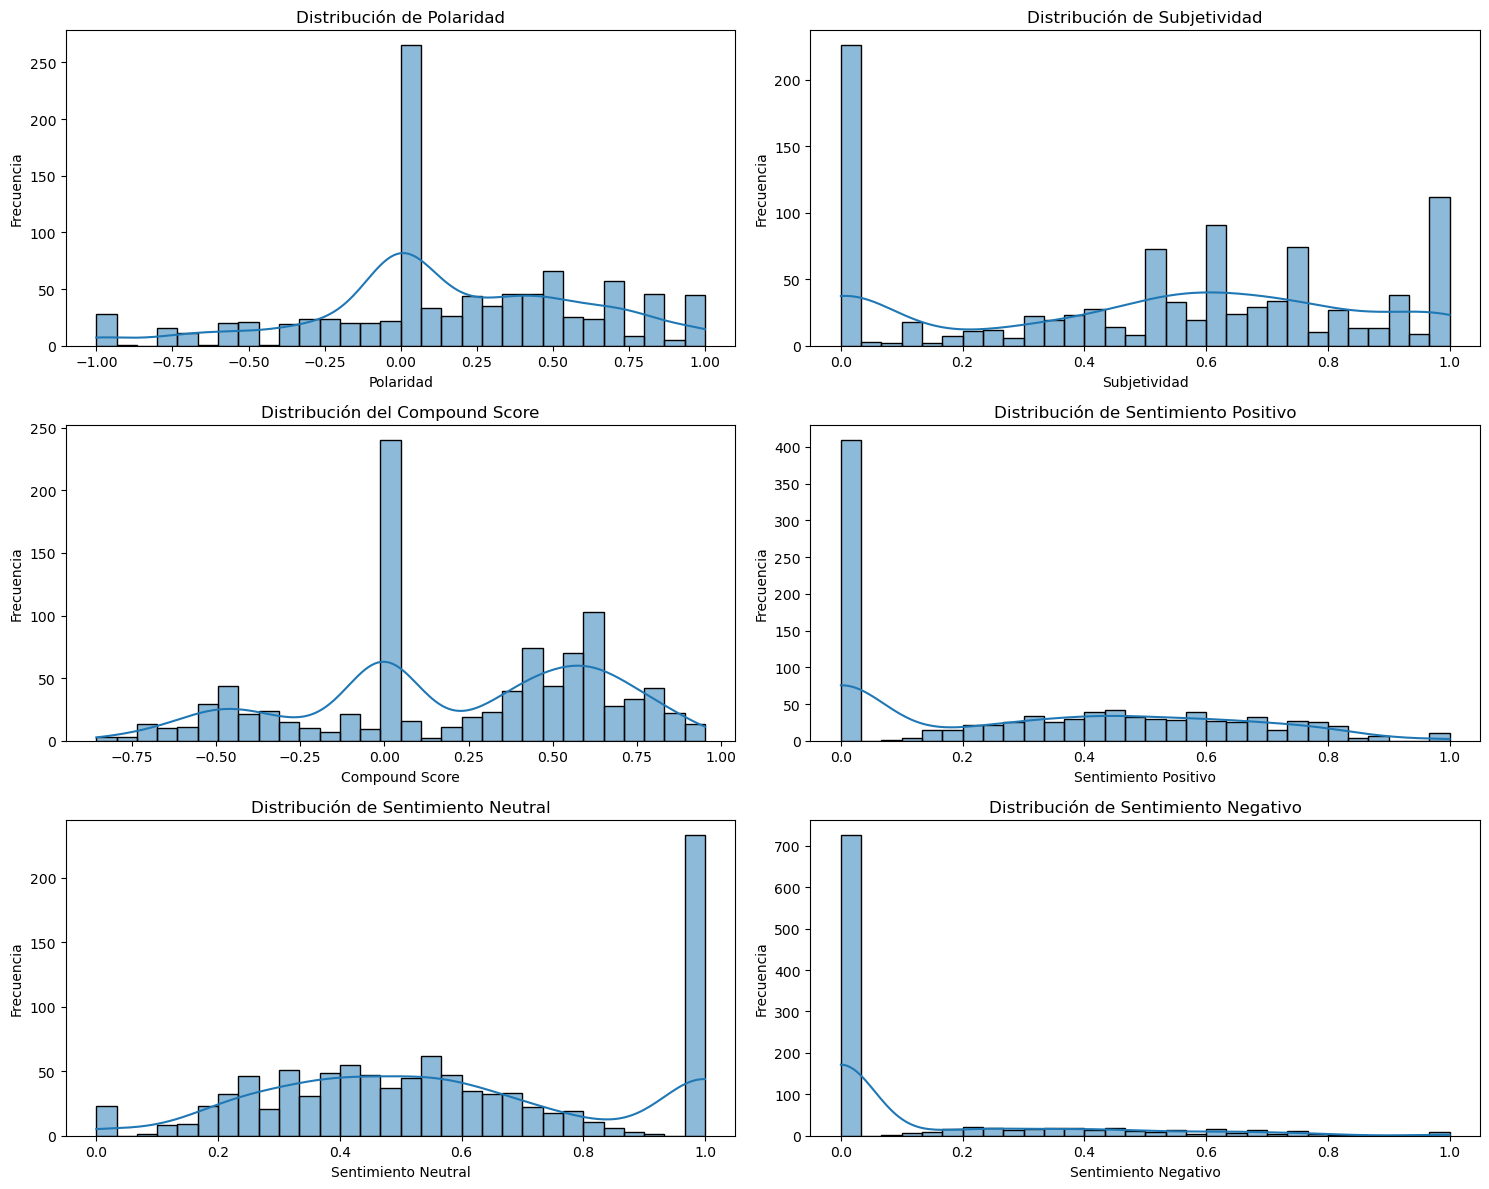

In [17]:
# Configurar el tamaño de las figuras
plt.figure(figsize=(15, 12))

# Histograma de Polaridad
plt.subplot(3, 2, 1)
sns.histplot(df['Polarity'], kde=True, bins=30)
plt.title('Distribución de Polaridad')
plt.xlabel('Polaridad')
plt.ylabel('Frecuencia')


# Histograma de Subjetividad
plt.subplot(3, 2, 2)
sns.histplot(df['Subjectivity'], kde=True, bins=30)
plt.title('Distribución de Subjetividad')
plt.xlabel('Subjetividad')
plt.ylabel('Frecuencia')

# Histograma de Compound Score
plt.subplot(3, 2, 3)
sns.histplot(df['Compound'], kde=True, bins=30)
plt.title('Distribución del Compound Score')
plt.xlabel('Compound Score')
plt.ylabel('Frecuencia')

# Histograma de Sentimiento Positivo
plt.subplot(3, 2, 4)
sns.histplot(df['Positive'], kde=True, bins=30)
plt.title('Distribución de Sentimiento Positivo')
plt.xlabel('Sentimiento Positivo')
plt.ylabel('Frecuencia')


# Histograma de Sentimiento Neutral
plt.subplot(3, 2, 5)
sns.histplot(df['Neutral'], kde=True, bins=30)
plt.title('Distribución de Sentimiento Neutral')
plt.xlabel('Sentimiento Neutral')
plt.ylabel('Frecuencia')

# Histograma de Sentimiento Negativo
plt.subplot(3, 2, 6)
sns.histplot(df['Negative'], kde=True, bins=30)
plt.title('Distribución de Sentimiento Negativo')
plt.xlabel('Sentimiento Negativo')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

<H1>Version 2</H1>

In [18]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import pipeline
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
from nltk import ngrams

# Descargar stopwords y tokenizador
nltk.download('stopwords')
nltk.download('punkt')

# Cargar dataset desde un archivo TSV (por ejemplo, reseñas de restaurantes)
url = '/home/julio/jupyter_files/Curso_ML/Restaurant_Reviews.tsv'
df = pd.read_csv(url, sep='\t')  # Se especifica 'sep' para asegurarse de que use tabulación

[nltk_data] Downloading package stopwords to /home/julio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/julio/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [19]:
# Mostrar las primeras filas del dataset
#df.head()

# Limpiar texto
def clean_text(text):
    text = re.sub(r'\d+', '', text)  # Eliminar números
    text = re.sub(r'[^\w\s]', '', text)  # Eliminar signos de puntuación
    text = text.lower()  # Convertir a minúsculas
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)

df['Cleaned_Review'] = df['Review'].apply(clean_text)

In [20]:
# Análisis de Sentimiento con TextBlob
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity, analysis.sentiment.subjectivity

df[['Polarity', 'Subjectivity']] = df['Cleaned_Review'].apply(lambda x: pd.Series(get_sentiment(x)))

In [21]:
# Análisis de Sentimiento con VADER
analyzer = SentimentIntensityAnalyzer()

def get_vader_emotions(text):
    vader_result = analyzer.polarity_scores(text)
    return vader_result['compound'], vader_result['pos'], vader_result['neu'], vader_result['neg']

df[['Compound', 'Positive', 'Neutral', 'Negative']] = df['Cleaned_Review'].apply(lambda x: pd.Series(get_vader_emotions(x)))

In [22]:
# Cargar el pipeline de emociones (BERT)
emotion_pipeline = pipeline('text-classification', model='bhadresh-savani/bert-base-uncased-emotion')

def get_emotions(text):
    result = emotion_pipeline(text)
    return result[0]['label'], result[0]['score']

df[['Emotion_Label', 'Emotion_Score']] = df['Cleaned_Review'].apply(lambda x: pd.Series(get_emotions(x)))

/home/julio/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


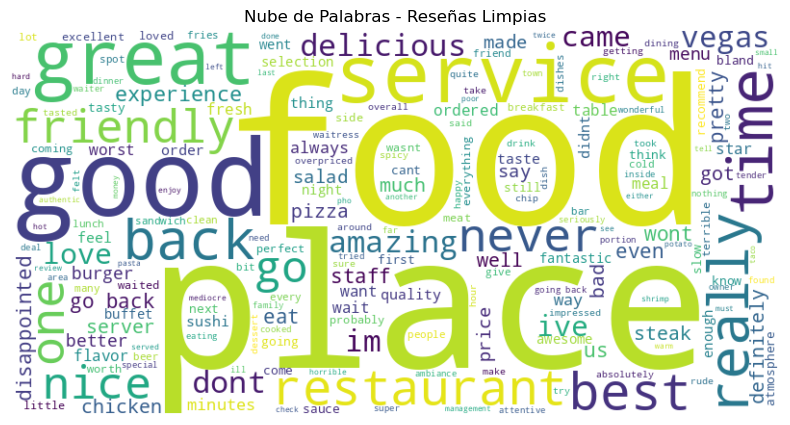

In [23]:
# 1. Nube de Palabras (Word Cloud)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['Cleaned_Review']))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras - Reseñas Limpias')
plt.show()

In [24]:
# 2. Análisis de Bigramas
tokenized_reviews = df['Cleaned_Review'].apply(word_tokenize)
bigrams = tokenized_reviews.apply(lambda x: list(ngrams(x, 2)))
bigram_freq = Counter([item for sublist in bigrams for item in sublist])
print("Bigramas más comunes:", bigram_freq.most_common(10))

Bigramas más comunes: [(('go', 'back'), 18), (('great', 'food'), 8), (('good', 'food'), 8), (('going', 'back'), 7), (('food', 'good'), 7), (('great', 'service'), 6), (('really', 'good'), 6), (('first', 'time'), 6), (('great', 'place'), 6), (('food', 'service'), 5)]


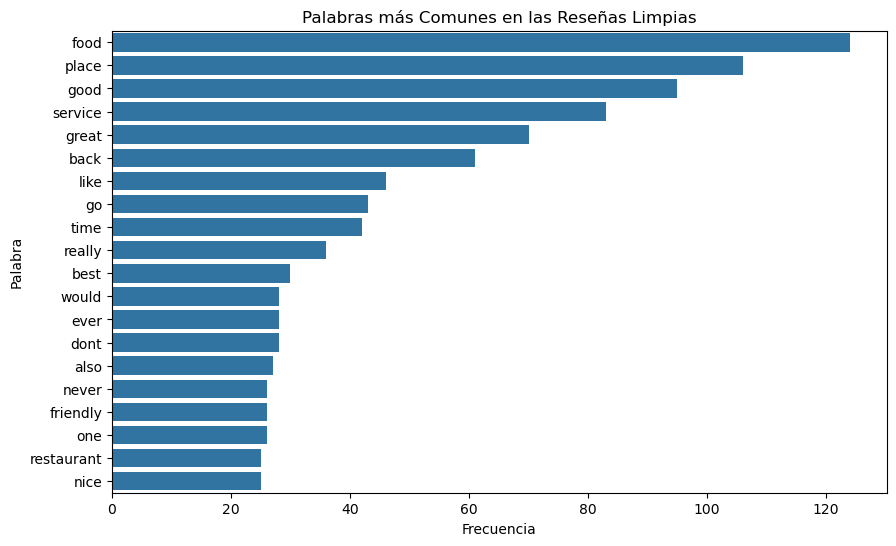

In [25]:
# 3. Análisis de Frecuencia de Palabras
word_freq = Counter(" ".join(df['Cleaned_Review']).split())
common_words = word_freq.most_common(20)
df_common_words = pd.DataFrame(common_words, columns=['Palabra', 'Frecuencia'])

plt.figure(figsize=(10, 6))
sns.barplot(x='Frecuencia', y='Palabra', data=df_common_words)
plt.title('Palabras más Comunes en las Reseñas Limpias')
plt.show()

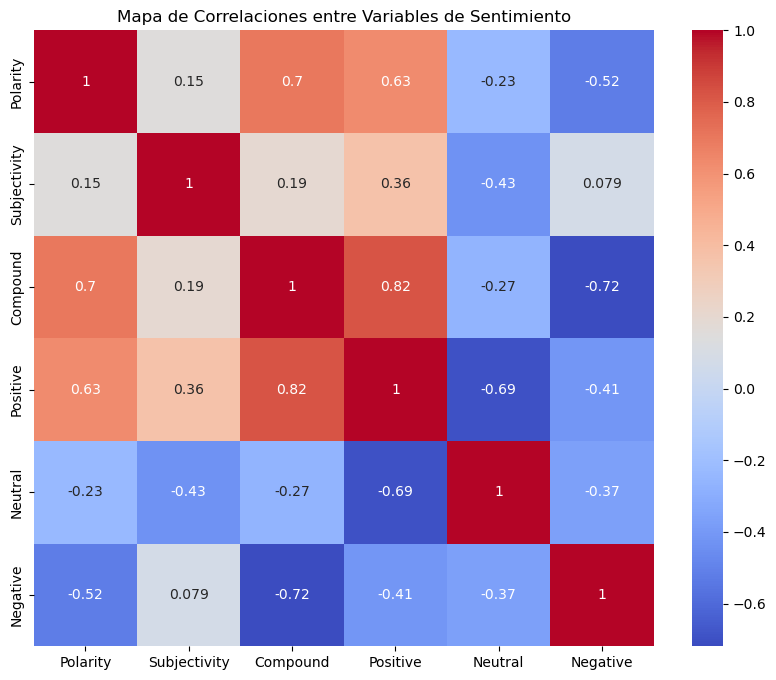

In [26]:
# 4. Análisis de Correlación entre Variables
plt.figure(figsize=(10, 8))
sns.heatmap(df[['Polarity', 'Subjectivity', 'Compound', 'Positive', 'Neutral', 'Negative']].corr(), annot=True, cmap='coolwarm')
plt.title('Mapa de Correlaciones entre Variables de Sentimiento')
plt.show()


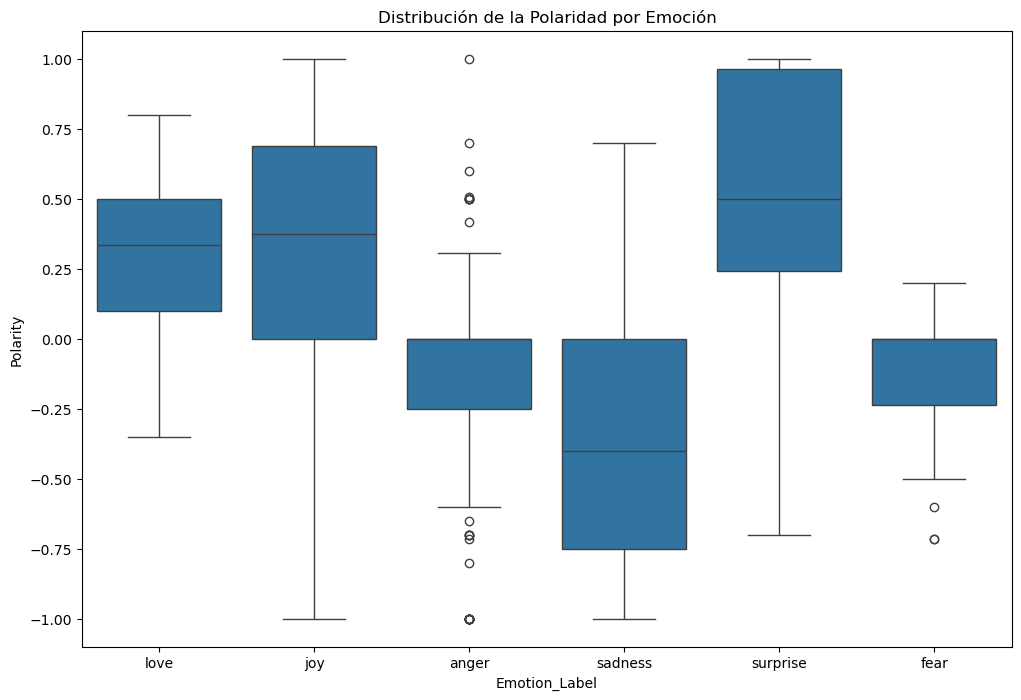

In [27]:
# 5. Análisis de Emociones por Categoría
plt.figure(figsize=(12, 8))
sns.boxplot(x='Emotion_Label', y='Polarity', data=df)
plt.title('Distribución de la Polaridad por Emoción')
plt.show()

              precision    recall  f1-score   support

           0       0.76      0.85      0.80       152
           1       0.82      0.72      0.77       148

    accuracy                           0.79       300
   macro avg       0.79      0.79      0.79       300
weighted avg       0.79      0.79      0.79       300



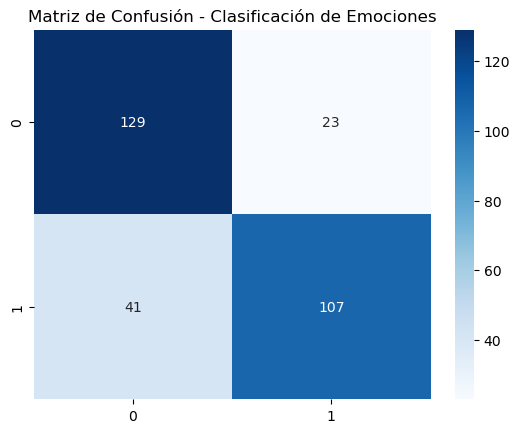

In [28]:
# 6. Clasificación Basada en Sentimientos (Random Forest)
df['Emotion_Label_Cat'] = pd.Categorical(df['Emotion_Label']).codes
X = df[['Polarity', 'Subjectivity', 'Compound', 'Positive', 'Neutral', 'Negative']]
y = df['Liked']  # Columna con etiquetas 'Liked'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Clasificación de Emociones')
plt.show()

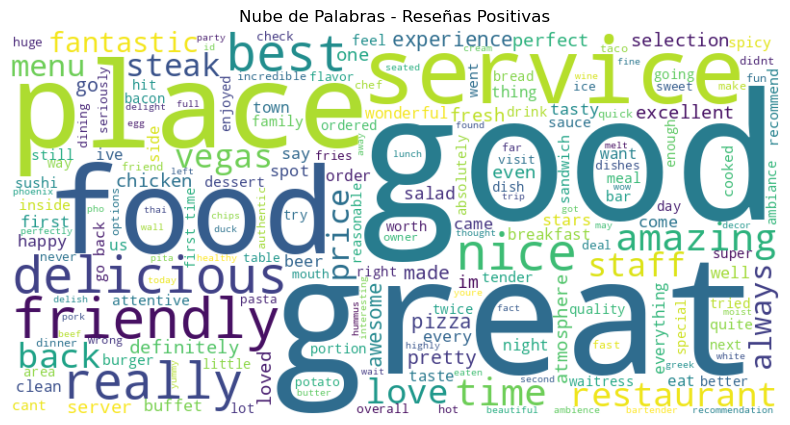

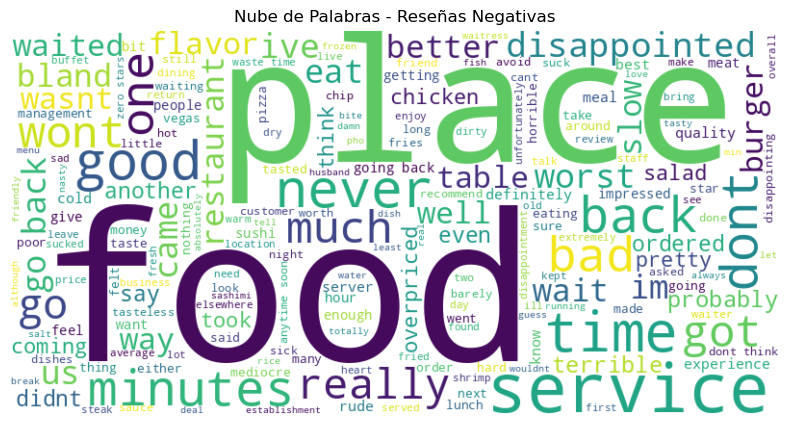

In [30]:
# 7. Nube de Palabras para Reseñas Positivas y Negativas
positive_reviews = df[df['Liked'] == 1]
negative_reviews = df[df['Liked'] == 0]

# Nube de palabras para reseñas positivas
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(positive_reviews['Cleaned_Review']))
plt.figure(figsize=(10, 5))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras - Reseñas Positivas')
plt.show()

# Nube de palabras para reseñas negativas
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(negative_reviews['Cleaned_Review']))
plt.figure(figsize=(10, 5))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras - Reseñas Negativas')
plt.show()

In [31]:
df

,Review,Liked,Cleaned_Review,Polarity,Subjectivity,Compound,Positive,Neutral,Negative,Emotion_Label,Emotion_Score,Emotion_Label_Cat
0,Wow... Loved this place.,1,wow loved place,0.400000,0.900000,0.8271,0.885,0.115,0.000,love,0.949841,3
1,Crust is not good.,0,crust good,0.700000,0.600000,0.4404,0.744,0.256,0.000,joy,0.976134,2
2,Not tasty and the texture was just nasty.,0,tasty texture nasty,-1.000000,1.000000,-0.5574,0.000,0.357,0.643,anger,0.827385,0
3,Stopped by during the late May bank holiday of...,1,stopped late may bank holiday rick steve recom...,0.200000,0.700000,0.6908,0.455,0.414,0.131,love,0.991881,3
4,The selection on the menu was great and so wer...,1,selection menu great prices,0.800000,0.750000,0.6249,0.577,0.423,0.000,joy,0.977900,2
...,...,...,...,...,...,...,...,...,...,...,...,...
995,I think food should have flavor and texture an...,0,think food flavor texture lacking,0.000000,0.000000,0.0000,0.000,1.000,0.000,fear,0.629882,1
996,Appetite instantly gone.,0,appetite instantly gone,0.000000,0.666667,0.0000,0.000,1.000,0.000,joy,0.897203,2
997,Overall I was not impressed and would not go b...,0,overall impressed would go back,0.333333,0.333333,0.4767,0.437,0.563,0.000,surprise,0.989575,5
998,"The whole experience was underwhelming, and I ...",0,whole experience underwhelming think well go n...,0.100000,0.200000,0.2732,0.189,0.811,0.000,joy,0.981474,2
